# Imports

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor
import random
random.seed(123)

plt.rcParams['figure.figsize'] = [14, 3]

# Load dataset

In [75]:
users = pd.read_csv('itmo-andan-competition/users.csv', sep=',')
print(f'dataset shape: {users.shape}')
users.head(7)

dataset shape: (27769, 4)


,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4
5,5,2,22,5
6,6,1,21,6


In [76]:
history = pd.read_csv('itmo-andan-competition/history.csv', sep=',')
print(f'dataset shape: {history.shape}')
history.head(7)

dataset shape: (1147857, 4)


,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
5,5,70.00,2,16334
6,10,73.22,1,25931


In [77]:
ads = pd.read_csv('itmo-andan-competition/ads.csv', sep=',')
print(f'dataset shape: {ads.shape}')
ads.head(7)

dataset shape: (1008, 7)


,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",3
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4
5,141.0,1288,1322,"3,8,11,15",856,"111,217,235,247,292,340,398,540,541,546,581,61...",5
6,250.0,1198,1451,"1,3,7,10,13,18",336,"24,43,96,124,150,256,299,313,430,450,552,557,5...",6


# Split into train and test

In [79]:
mask = ads['ad_id'] < 700
X_train = ads[mask]
X_test = ads[~mask]

In [86]:
y_train = pd.read_csv('itmo-andan-competition/target.csv', sep=',')
y_train.drop('ad_id', inplace=True, axis=1)

# Feature engineering

In [29]:
def get_ta(ad):
    ids = [int(i) for i in ad['user_ids'].split(',')]
    aus = ad['audience_size']
    ta = users[users['user_id'].isin(ids)]
    assert ta.shape[0] == aus
    return ta

def get_n_tcities(ta):
    return sum([1 for i in ta['city_id'].value_counts().values if i != 0])

def get_ages_mean_std(ta): 
    ta = ta.astype('int')
    ages = ta[(ta['age'] >= 14) & (ta['age'] <= 80)]['age']
    if ages.empty:
        ages = np.array([0])
    return [ages.mean(), ages.std()]

def get_male_perc(ta):
    return ta['sex'].value_counts(normalize=True)[1] * 100

def get_new_features(ad):
    ta = get_ta(ad)
    ta = ta.astype('int')
    new_cols = []
    new_cols.append(get_n_tcities(ta))
    new_cols += get_ages_mean_std(ta)
    new_cols.append(get_male_perc(ta))
    return new_cols

def pub_us_hist_features(ad, hist_grouped):
    ta = [int(i) for i in ad['user_ids'].split(',')]
    pubs = [int(i) for i in ad.publishers.split(',')]
    ta_tp_history = hist_grouped[((hist_grouped['publisher'].isin(pubs)) & (hist_grouped['user_id'].isin(ta)))]
    h = ta_tp_history.groupby('user_id').agg(['sum'])
    h.columns = ['publisher_size', 'n_seen_ads_on_theese_platforms']
    agg_funcs = ['mean', 'std', 'sum']
    x = h['n_seen_ads_on_theese_platforms'].agg(agg_funcs)
    x.index = [
                 'ta_tp_seen_ads_mean', 'ta_tp_seen_ads_std', 'ta_tp_seen_ads_sum'
               ]
    x['n_of_people_who_didnt_see'] = len(ta) - len(h)
    x['n_of_people_who_saw_at_least_once'] = h['n_seen_ads_on_theese_platforms'].value_counts()[0:].sum()
    return x

def feature_engineering(X, hist):
    X['users'] = [list(map(int, i.split(','))) for i in X['user_ids']] 
    X['time_shown'] = X['hour_end'] - X['hour_start']
    hist['day_hour'] = hist['hour'] % 24
    new_X = pd.DataFrame()

    new_X['cpm'] = X['cpm']
    new_X['time_shown'] = X['time_shown']
    new_X['audience_size'] = X['audience_size']

    ui_X = X.apply(get_new_features, axis=1, result_type='expand')
    ui_cols = ['n_target_cities', 'tage_mean', 'tage_std', 'male_perc']
    ui_X.columns = ui_cols
    new_X = pd.concat([new_X, ui_X], axis=1)

    hist_grouped = hist.groupby(['publisher', 'user_id'])['cpm'].agg(['size']).reset_index()
    pub_us_hist_X = X.apply(
        pub_us_hist_features, axis=1, result_type='expand', args=(hist_grouped,)
    )
    new_X = pd.concat([new_X, pub_us_hist_X], axis=1)

    return new_X

In [80]:
X_train = feature_engineering(X_train, history)

<ipython-input-29-5ccedf1e22e3>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['users'] = [list(map(int, i.split(','))) for i in X['user_ids']]
<ipython-input-29-5ccedf1e22e3>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['time_shown'] = X['hour_end'] - X['hour_start']


In [81]:
X_test = feature_engineering(X_test, history)

<ipython-input-29-5ccedf1e22e3>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['users'] = [list(map(int, i.split(','))) for i in X['user_ids']]
<ipython-input-29-5ccedf1e22e3>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['time_shown'] = X['hour_end'] - X['hour_start']


In [54]:
pd.DataFrame(X).head(1)

,cpm,time_shown,audience_size,n_target_cities,tage_mean,tage_std,male_perc,ta_tp_seen_ads_mean,ta_tp_seen_ads_std,ta_tp_seen_ads_sum,n_of_people_who_didnt_see,n_of_people_who_saw_at_least_once
0,220.0,95,1906,7.0,29.231034,10.551746,53.777545,11.325123,24.068477,4598.0,1500.0,406.0


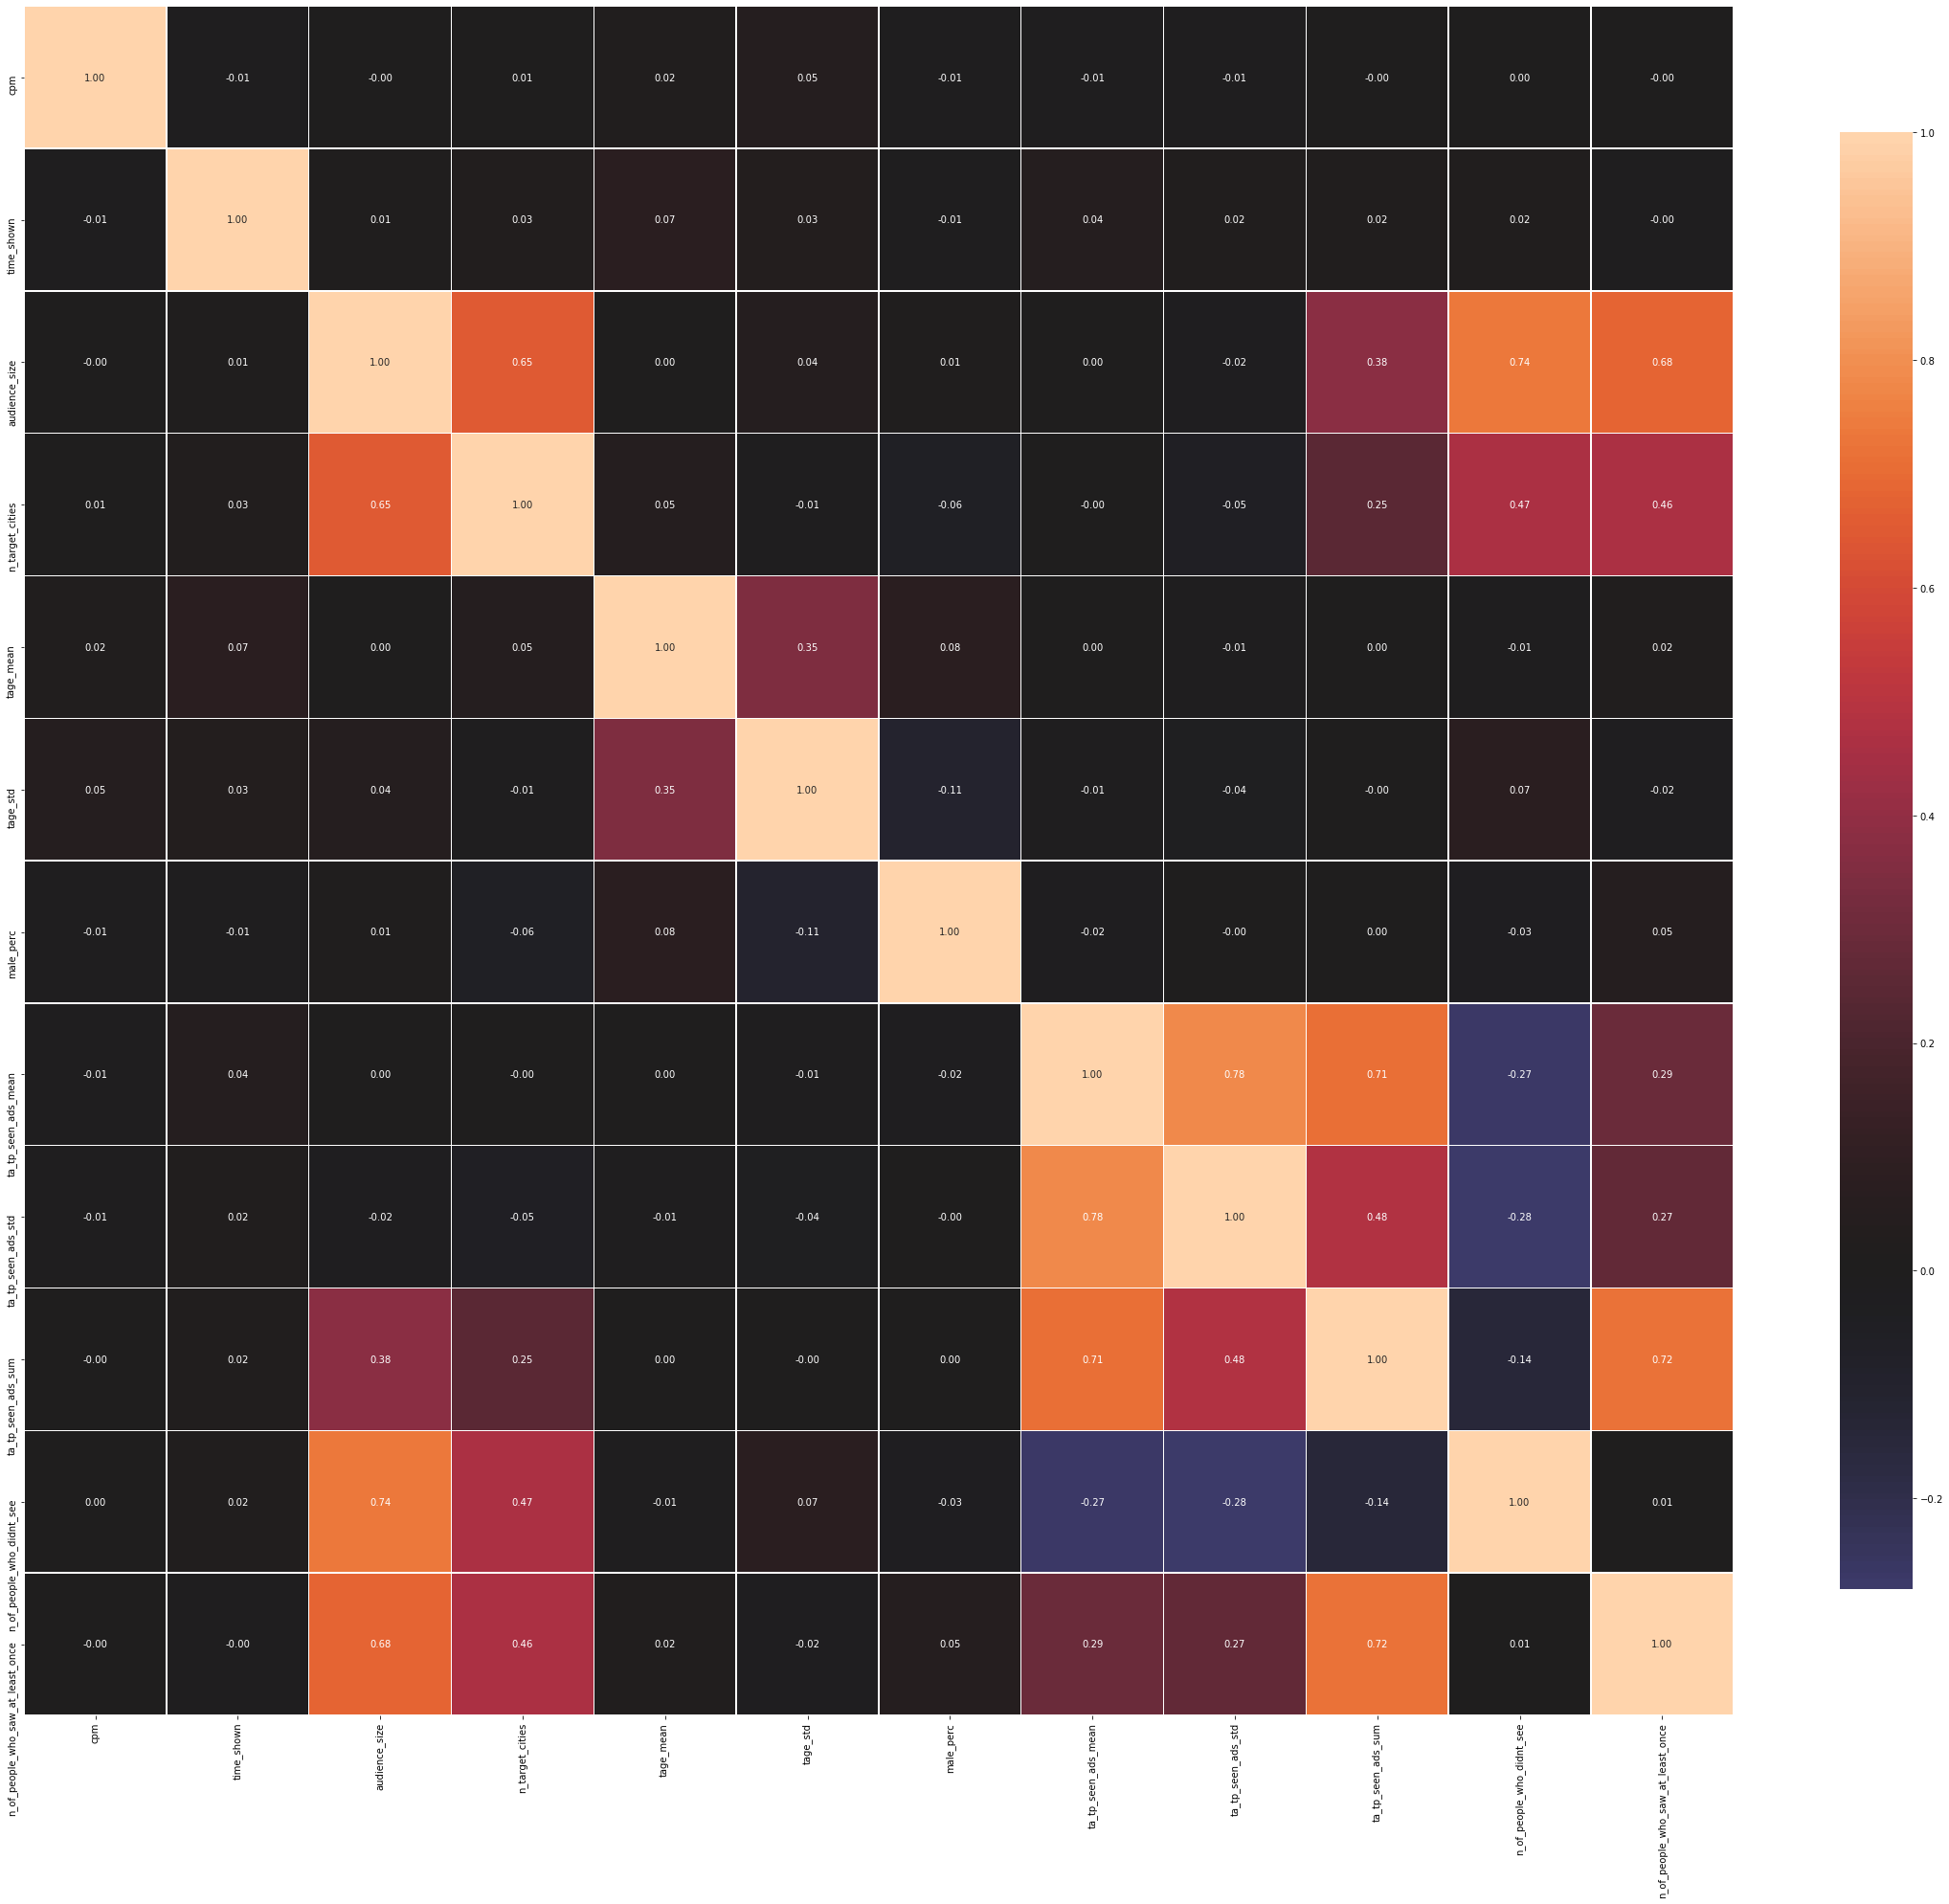

In [55]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(40,40))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(X)

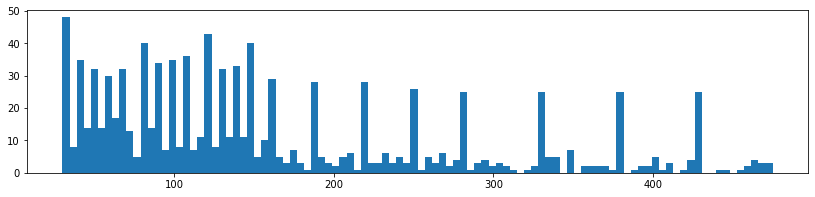

In [57]:
plt.hist(X.cpm, bins=100)
plt.show()

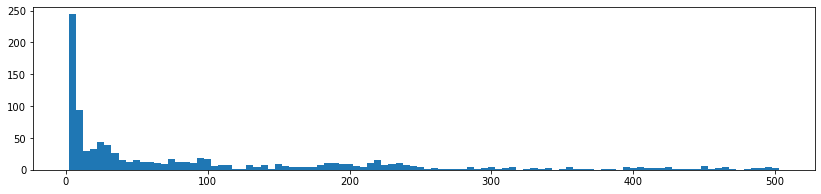

In [58]:
plt.hist(X.time_shown, bins=100)
plt.show()

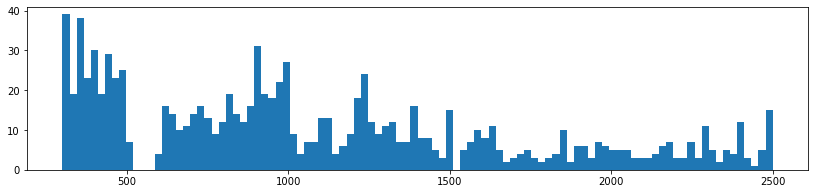

In [59]:
plt.hist(X.audience_size, bins=100)
plt.show()

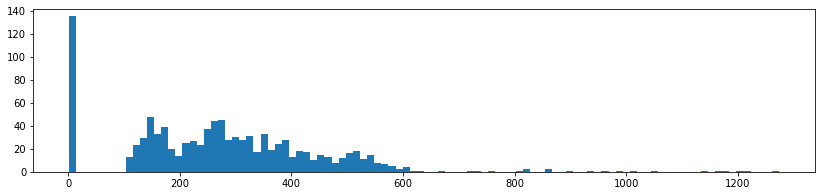

In [60]:
plt.hist(X.n_target_cities, bins=100)
plt.show()

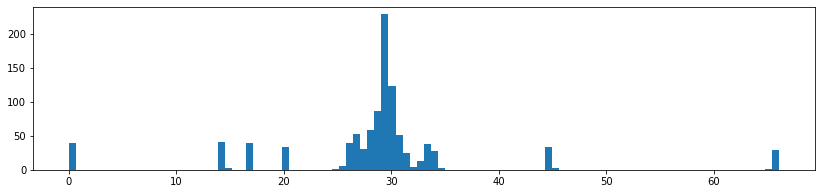

In [61]:
plt.hist(X.tage_mean, bins=100)
plt.show()

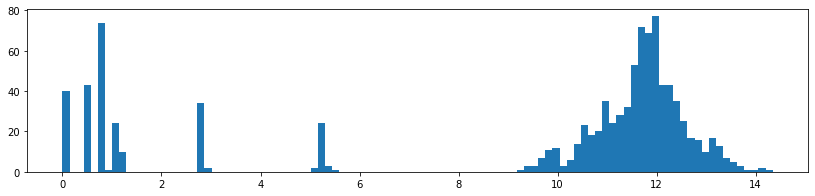

In [62]:
plt.hist(X.tage_std, bins=100)
plt.show()

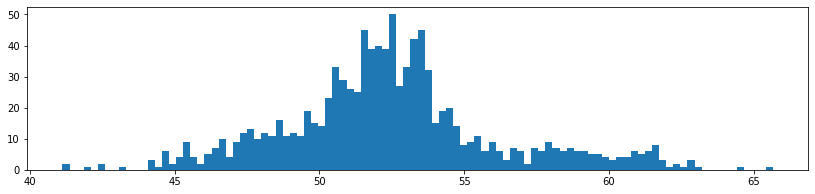

In [63]:
plt.hist(X.male_perc, bins=100)
plt.show()

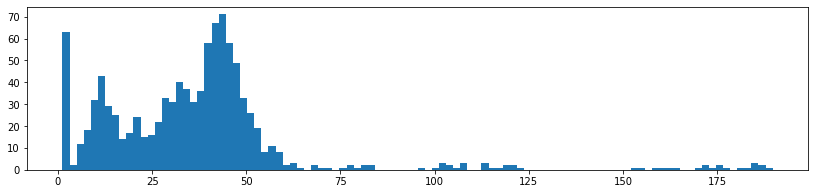

In [64]:
plt.hist(X.ta_tp_seen_ads_mean, bins=100)
plt.show()

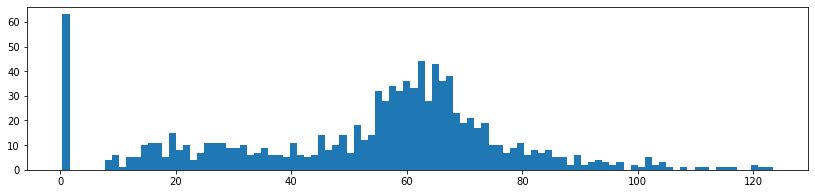

In [65]:
plt.hist(X.ta_tp_seen_ads_std, bins=100)
plt.show()

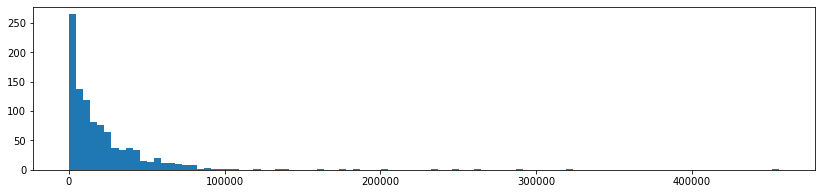

In [66]:
plt.hist(X.ta_tp_seen_ads_sum, bins=100)
plt.show()

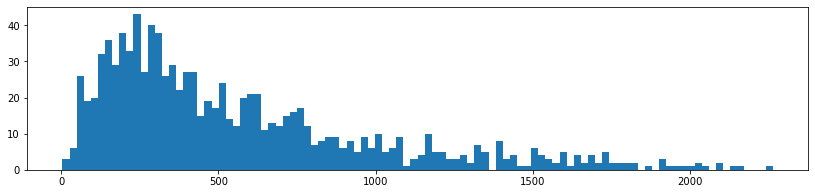

In [67]:
plt.hist(X.n_of_people_who_didnt_see, bins=100)
plt.show()

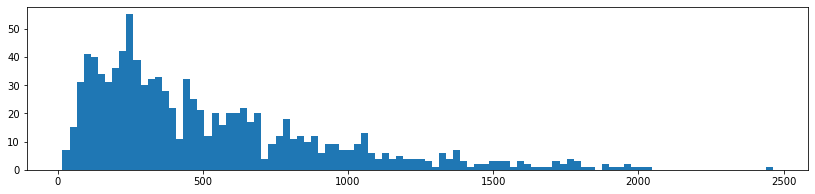

In [68]:
plt.hist(X.n_of_people_who_saw_at_least_once, bins=100)
plt.show()

In [82]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [83]:
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

In [89]:
r = Ridge(alpha=1).fit(X_train, y_train)
print(f"Train MAPE:{mean_absolute_percentage_error(y_train, r.predict(X_train))}")

Train MAPE:16.799129177351322


In [90]:
prediction = r.predict(X_test)

In [92]:
sample_submission = pd.read_csv("itmo-andan-competition/sample_solution.csv", sep=',')

In [93]:
my_submission = pd.DataFrame({'ad_id':sample_submission['ad_id'],'at_least_one':prediction.ravel()})

In [94]:
filename = 'vkCup5.csv'

my_submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: vkCup5.csv


In [98]:
catboost = CatBoostRegressor()
catboost.fit(X_train, y_train)

Learning rate set to 0.038699
0:	learn: 0.1434492	total: 79ms	remaining: 1m 18s
1:	learn: 0.1402362	total: 88.8ms	remaining: 44.3s
2:	learn: 0.1375942	total: 97.3ms	remaining: 32.3s
3:	learn: 0.1346818	total: 106ms	remaining: 26.4s
4:	learn: 0.1322961	total: 115ms	remaining: 22.9s
5:	learn: 0.1297976	total: 124ms	remaining: 20.5s
6:	learn: 0.1275082	total: 132ms	remaining: 18.8s
7:	learn: 0.1252710	total: 141ms	remaining: 17.5s
8:	learn: 0.1229443	total: 150ms	remaining: 16.5s
9:	learn: 0.1204933	total: 159ms	remaining: 15.8s
10:	learn: 0.1182465	total: 168ms	remaining: 15.1s
11:	learn: 0.1162639	total: 177ms	remaining: 14.5s
12:	learn: 0.1138779	total: 185ms	remaining: 14.1s
13:	learn: 0.1116859	total: 200ms	remaining: 14.1s
14:	learn: 0.1092370	total: 210ms	remaining: 13.8s
15:	learn: 0.1070611	total: 224ms	remaining: 13.8s
16:	learn: 0.1048001	total: 233ms	remaining: 13.4s
17:	learn: 0.1031184	total: 245ms	remaining: 13.4s
18:	learn: 0.1013845	total: 253ms	remaining: 13.1s
19:	learn

167:	learn: 0.0250259	total: 1.87s	remaining: 9.28s
168:	learn: 0.0248430	total: 1.89s	remaining: 9.28s
169:	learn: 0.0247389	total: 1.9s	remaining: 9.28s
170:	learn: 0.0246111	total: 1.91s	remaining: 9.25s
171:	learn: 0.0243981	total: 1.92s	remaining: 9.24s
172:	learn: 0.0242356	total: 1.93s	remaining: 9.21s
173:	learn: 0.0240938	total: 1.93s	remaining: 9.18s
174:	learn: 0.0239917	total: 1.94s	remaining: 9.15s
175:	learn: 0.0239498	total: 1.95s	remaining: 9.13s
176:	learn: 0.0238601	total: 1.96s	remaining: 9.1s
177:	learn: 0.0237979	total: 1.97s	remaining: 9.08s
178:	learn: 0.0237305	total: 1.97s	remaining: 9.05s
179:	learn: 0.0236242	total: 1.98s	remaining: 9.03s
180:	learn: 0.0235081	total: 1.99s	remaining: 9s
181:	learn: 0.0233494	total: 2s	remaining: 8.97s
182:	learn: 0.0231726	total: 2s	remaining: 8.95s
183:	learn: 0.0230992	total: 2.01s	remaining: 8.93s
184:	learn: 0.0229541	total: 2.02s	remaining: 8.9s
185:	learn: 0.0228174	total: 2.03s	remaining: 8.88s
186:	learn: 0.0226373	to

337:	learn: 0.0122340	total: 3.7s	remaining: 7.25s
338:	learn: 0.0122002	total: 3.72s	remaining: 7.25s
339:	learn: 0.0121707	total: 3.73s	remaining: 7.24s
340:	learn: 0.0121198	total: 3.75s	remaining: 7.24s
341:	learn: 0.0120658	total: 3.76s	remaining: 7.24s
342:	learn: 0.0120249	total: 3.77s	remaining: 7.23s
343:	learn: 0.0119853	total: 3.79s	remaining: 7.22s
344:	learn: 0.0119355	total: 3.8s	remaining: 7.21s
345:	learn: 0.0119039	total: 3.81s	remaining: 7.2s
346:	learn: 0.0118703	total: 3.82s	remaining: 7.19s
347:	learn: 0.0118242	total: 3.83s	remaining: 7.17s
348:	learn: 0.0117674	total: 3.84s	remaining: 7.16s
349:	learn: 0.0117250	total: 3.85s	remaining: 7.14s
350:	learn: 0.0116856	total: 3.85s	remaining: 7.13s
351:	learn: 0.0116391	total: 3.87s	remaining: 7.12s
352:	learn: 0.0116024	total: 3.88s	remaining: 7.11s
353:	learn: 0.0115645	total: 3.89s	remaining: 7.1s
354:	learn: 0.0115260	total: 3.91s	remaining: 7.1s
355:	learn: 0.0114771	total: 3.92s	remaining: 7.1s
356:	learn: 0.0114

519:	learn: 0.0071078	total: 5.54s	remaining: 5.11s
520:	learn: 0.0070902	total: 5.55s	remaining: 5.1s
521:	learn: 0.0070658	total: 5.56s	remaining: 5.09s
522:	learn: 0.0070521	total: 5.57s	remaining: 5.08s
523:	learn: 0.0070432	total: 5.58s	remaining: 5.07s
524:	learn: 0.0070323	total: 5.59s	remaining: 5.06s
525:	learn: 0.0070241	total: 5.6s	remaining: 5.04s
526:	learn: 0.0070031	total: 5.61s	remaining: 5.03s
527:	learn: 0.0069897	total: 5.61s	remaining: 5.02s
528:	learn: 0.0069738	total: 5.62s	remaining: 5.01s
529:	learn: 0.0069707	total: 5.63s	remaining: 4.99s
530:	learn: 0.0069496	total: 5.64s	remaining: 4.98s
531:	learn: 0.0069369	total: 5.65s	remaining: 4.97s
532:	learn: 0.0069217	total: 5.66s	remaining: 4.96s
533:	learn: 0.0068971	total: 5.67s	remaining: 4.94s
534:	learn: 0.0068878	total: 5.68s	remaining: 4.93s
535:	learn: 0.0068830	total: 5.68s	remaining: 4.92s
536:	learn: 0.0068624	total: 5.69s	remaining: 4.91s
537:	learn: 0.0068435	total: 5.7s	remaining: 4.89s
538:	learn: 0.0

689:	learn: 0.0047926	total: 7.17s	remaining: 3.22s
690:	learn: 0.0047809	total: 7.19s	remaining: 3.21s
691:	learn: 0.0047734	total: 7.21s	remaining: 3.21s
692:	learn: 0.0047563	total: 7.22s	remaining: 3.2s
693:	learn: 0.0047417	total: 7.23s	remaining: 3.19s
694:	learn: 0.0047270	total: 7.24s	remaining: 3.18s
695:	learn: 0.0047138	total: 7.25s	remaining: 3.17s
696:	learn: 0.0047072	total: 7.26s	remaining: 3.15s
697:	learn: 0.0046938	total: 7.27s	remaining: 3.15s
698:	learn: 0.0046854	total: 7.29s	remaining: 3.14s
699:	learn: 0.0046689	total: 7.3s	remaining: 3.13s
700:	learn: 0.0046566	total: 7.31s	remaining: 3.12s
701:	learn: 0.0046439	total: 7.32s	remaining: 3.11s
702:	learn: 0.0046408	total: 7.34s	remaining: 3.1s
703:	learn: 0.0046245	total: 7.35s	remaining: 3.09s
704:	learn: 0.0046091	total: 7.36s	remaining: 3.08s
705:	learn: 0.0046012	total: 7.37s	remaining: 3.07s
706:	learn: 0.0045958	total: 7.39s	remaining: 3.06s
707:	learn: 0.0045905	total: 7.4s	remaining: 3.05s
708:	learn: 0.00

863:	learn: 0.0032919	total: 9.01s	remaining: 1.42s
864:	learn: 0.0032913	total: 9.02s	remaining: 1.41s
865:	learn: 0.0032898	total: 9.04s	remaining: 1.4s
866:	learn: 0.0032816	total: 9.05s	remaining: 1.39s
867:	learn: 0.0032734	total: 9.06s	remaining: 1.38s
868:	learn: 0.0032669	total: 9.06s	remaining: 1.37s
869:	learn: 0.0032562	total: 9.07s	remaining: 1.35s
870:	learn: 0.0032466	total: 9.08s	remaining: 1.34s
871:	learn: 0.0032396	total: 9.09s	remaining: 1.33s
872:	learn: 0.0032335	total: 9.1s	remaining: 1.32s
873:	learn: 0.0032262	total: 9.11s	remaining: 1.31s
874:	learn: 0.0032237	total: 9.11s	remaining: 1.3s
875:	learn: 0.0032189	total: 9.12s	remaining: 1.29s
876:	learn: 0.0032059	total: 9.13s	remaining: 1.28s
877:	learn: 0.0031998	total: 9.14s	remaining: 1.27s
878:	learn: 0.0031870	total: 9.15s	remaining: 1.26s
879:	learn: 0.0031793	total: 9.16s	remaining: 1.25s
880:	learn: 0.0031678	total: 9.16s	remaining: 1.24s
881:	learn: 0.0031591	total: 9.17s	remaining: 1.23s
882:	learn: 0.0

In [99]:
prediction = catboost.predict(X_test)

In [100]:
my_submission = pd.DataFrame({'ad_id':sample_submission['ad_id'],'at_least_one':prediction.ravel()})

In [101]:
filename = 'vkCup6.csv'

my_submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: vkCup6.csv


In [104]:
catboost.save_model(fname="catboost1")